In [ ]:
# First let's import the packages we will use in this project
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import matplotlib
# Set the plotting style to 'ggplot' for a clean, professional look with grid background
plt.style.use('ggplot')
from matplotlib.pyplot import figure

# Enable inline plotting so that plots appear directly in the notebook output
%matplotlib inline
# Set the default figure size to 12 inches wide by 8 inches tall for all plots
matplotlib.rcParams['figure.figsize'] = (12,8)

# Disable the SettingWithCopyWarning to avoid false positive warnings when modifying DataFrames
pd.options.mode.chained_assignment = None
# Configure pandas to display all rows in DataFrame outputs by default
pd.set_option('display.max_rows', None)

In [20]:
df = pd.read_csv("who_alcohol.csv")
df.head(10)

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode
0,Italy,ITA,2003,Both sexes,9.622988,7.965011,11.388622,3.423611,SA_0000001688
1,"Tanzania, United Republic of",TZA,2006,Both sexes,6.337646,4.767623,8.109324,3.341701,SA_0000001688
2,Cyprus,CYP,2017,Both sexes,6.117152,4.627244,7.798063,3.170819,SA_0000001688
3,Sierra Leone,SLE,2019,Both sexes,0.253228,0.100851,0.567434,0.466583,SA_0000001688
4,Philippines,PHL,2017,Both sexes,6.023875,4.681733,7.536645,2.854912,SA_0000001688
5,Qatar,QAT,2007,Both sexes,1.172084,0.612613,1.854674,1.242061,SA_0000001688
6,Pakistan,PAK,2018,Both sexes,0.104081,0.036438,0.340114,0.303676,SA_0000001688
7,Andorra,AND,2005,Both sexes,13.008124,11.013494,14.829454,3.815960,SA_0000001688
8,Slovenia,SVN,2000,Both sexes,12.477747,10.599043,14.375460,3.776417,SA_0000001688
9,Maldives,MDV,2009,Both sexes,1.963434,0.535407,3.335924,2.800517,SA_0000001688


As we can see, every country has one row for each year between 2000 and 2022 inclusive. 

Let's check for any missing values

In [ ]:
# Calculate % of missing values per column. np.mean() on boolean Series (True=1, False=0) gives proportion of True values. Sums number of True (1) and divides by total count

for col in df.columns:
    pct = np.mean(df[col].isnull())
    print(f"{pct * 100}%")


0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%


There are no missing values within the data. 

Let's convert alcohol_liters_per_capita into a more readable and easily understood form.

Let's convert it to units_per_capita_week (UK Units = 10ml Pure alcohol)
Let's also add a percentage of the UK low-risk guideline consumed per week (14 units)

In [27]:
df["units_per_capita_week"] = round(df["alcohol_liters_per_capita"] * 100 / 52, ndigits=1)
df["perc_uk_guideline"] = round(df["units_per_capita_week"] / 14 * 100, ndigits=1)
df.sort_values(by="units_per_capita_week", ascending=False).head()

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
1027,Romania,ROU,2002,Both sexes,19.497715,16.902455,22.251088,5.348633,SA_0000001688,37.5,267.9
3019,Romania,ROU,2003,Both sexes,19.389771,16.643855,22.116943,5.473088,SA_0000001688,37.3,266.4
803,Romania,ROU,2000,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1856,Romania,ROU,2001,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1768,Romania,ROU,2004,Both sexes,18.639676,15.787315,21.476058,5.688743,SA_0000001688,35.8,255.7


Let's begin analysing.

### Question 1: Are global alcohol consumption levels trending upward or downward overall?

In [ ]:
#finds average consumption per person per year
yearly = df.groupby("year")["alcohol_liters_per_capita"].aggregate('mean')
#convert year index into an explicit column
yearly = yearly.reset_index()


In [ ]:
#sets background
sns.set_style("ticks")
#sets size of labels, font etc
# poster, paper, notebook, talk
sns.set_context('poster', font_scale = 0.7)
plt.figure(figsize=(15, 5))

sns.lineplot(
    data=yearly,
    x = "year",
    y = "alcohol_liters_per_capita"
)

plt.title("Global Alcohol Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("Total Liters of Alcohol (Per Capita Sum)")

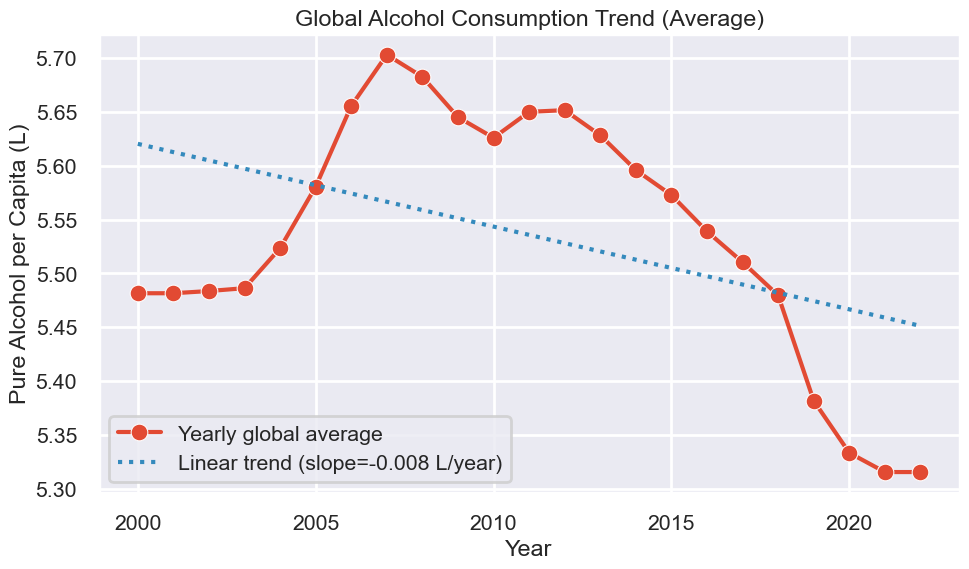

In [78]:
x = yearly["year"]
y = yearly["alcohol_liters_per_capita"]


#np.polyfit() finds best-fitting polynomial curve through data points: y ≈ m*x + c
#degree=1 means "a straight line"
m, c = np.polyfit(x, y, 1)

# This creates the function y = m*x + c
f = np.poly1d([m, c]) #takes a list of coefficients in descending order of polynomial degree
y_best_fit = f(x) # computes y values for all x values


sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plot the actual yearly global averages as a line chart
sns.lineplot(
    data=yearly,
    x=x,
    y=y,
    marker="o", # show dots at each year
    label="Yearly global average"
)

# Overlay the regression line
plt.plot(
    x,
    y_best_fit,
    linestyle=":",
    label=f"Linear trend (slope={m:.3f} L/year)"
)

# Add titles and axis labels so the plot is self-explanatory (portfolio essential)
plt.title("Global Alcohol Consumption Trend (Average)")
plt.xlabel("Year")
plt.ylabel("Pure Alcohol per Capita (L)")
plt.legend()
plt.tight_layout()

# Display the chart
plt.show()

We can see that Global alcohol consumption levels have been decreasing since 2012 worldwide. 

2020-2022 have all time lows, most likely due do the COVID-19 pandemic.